# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

Fill out this notebook, save it, and **submit it electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 09_Assignment_4.ipynb`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename=09_Assignment_4.ipynb
local_scp_filepath=~/git/iaml2017/${filename}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath} ${UUN}@${server_address}:${filename}
# rsync -rl ${local_scp_filepath} ${UUN}@${server_address}:${filename}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw1 09_Assignment_4.ipynb
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [174]:
from __future__ import print_function, division
%matplotlib inline

In [175]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import collections
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from termcolor import colored
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 --- [0 marks] ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [176]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 --- [5 marks] ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [177]:
print(X.info())
print(X.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845 entries, 0 to 2844
Columns: 1000 entries, abc to zone
dtypes: float64(1000)
memory usage: 21.7 MB
None
               abc      ability         able           ac       accept  \
count  2845.000000  2845.000000  2845.000000  2845.000000  2845.000000   
mean      0.002436     0.002149     0.006709     0.001454     0.002286   
std       0.030224     0.020739     0.034631     0.023100     0.021634   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.723914     0.420916     0.431380     0.519765     0.443354   

            access    according     acquired     actually      adaptec  \
count  2845.000000  2845.000000  2845.000000  2845.000000  2845.000000   
mean      0.003953     0.00

In [178]:
X.head(5)

,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
print("length of y: \t" + str(len(y)) + 
    "\n\ny is: \t\t" + str(y) +
    "\n\n'cats' is:\t " + str(cats) +
    "\n\n'y_num is: \t" + str(y_num))

#max and min

length of y: 	2845

y is: 		['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.hockey' ...,
 'comp.sys.ibm.pc.hardware' 'rec.sport.hockey' 'rec.sport.hockey']

'cats' is:	 ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.sport.baseball', 'rec.sport.hockey']

'y_num is: 	[3 3 4 ..., 1 4 4]


X are the training features. X has 2845 datapoints (the rows), which are each documents. X has 1000 feature columns which are words/abbreviations/meaningful collections of letters. 

Y is an array which contains the target for each document. The target is the newsgroup the document came from, for example alt.atheism. y = np.array(cats)[y_num] .  y_num is the target as an integer and (cats) converts that integer into the name of the target newsgroup.

### ========== Question 1.2 --- [2 marks] ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [180]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

### ========== Question 1.3 --- [6 marks] ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [181]:
#Find mean data point
singleMeanDataPointValue = np.apply_along_axis(np.mean, 0, X)

In [182]:
#Create empty matrix which will store 
euclideanDistances = []

#For each row (datapoint) in X, find Euclidean distance from mean datapoint and store in array
for index, row in X.iterrows():
    euclideanDistances.append(distance.euclidean(row, singleMeanDataPointValue))
    

print("Mean of the Euclidean distances of all data points from mean data point: " +
      str(np.mean(euclideanDistances)))

print("\nInertia of the model: " + str(kmeans.inertia_))

print("\nAdjusted rand index of model: " + str(adjusted_rand_score(y, kmeans.labels_)))


Mean of the Euclidean distances of all data points from mean data point: 0.954584949852

Inertia of the model: 2593.26745106

Adjusted rand index of model: 0.236459358529


Inertia is the "sum of squared distances of samples to their closest cluster center" [sklearn documentation].  Lower inertia implies a better fit.

Inertia can therefore be thought of as a measure of how far away the data points are from the cluster centres. 

Adjusted rand score is: The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
The raw RI score is then “adjusted for chance”. The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). [sklearn documentation]

Adjusted rand score can be thought of as how similar the clusters are to each other.

Here, the inertia is pretty large which means that it is not a very good fit and the datapoints in the clusters are a fair distance away from their cluster centres. 

The adjusted rand score is fairly low. An adjusted rand score of 0 would mean random clustering, so we have performed better than this, but not significantly.

### ========== Question 1.4 --- [3 marks] ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [183]:
#Display the number of datapoints with each target 
print("The number of datapoint with each label are as follows:")
collections.Counter(y)

The number of datapoint with each label are as follows:


Counter({'alt.atheism': 480,
         'comp.sys.ibm.pc.hardware': 590,
         'comp.sys.mac.hardware': 578,
         'rec.sport.baseball': 597,
         'rec.sport.hockey': 600})

In [184]:
#Display the number of datapoints that kmeans assigned to each target 
print("The number of datapoints that kmeans assigned to each cluster are as follows:")
collections.Counter(kmeans.labels_)

The number of datapoints that kmeans assigned to each cluster are as follows:


Counter({0: 1028, 1: 221, 2: 307, 3: 601, 4: 688})

The distribution of datapoints to cluster centres is not similar to the distribution of datapoints to each true label. There may be some overlap between the kmeans clusters and the true 5 clusters, but we can see that the kmeans clusters cannot contain all/most of the right data, as its distribution is so different as stated.

### ========== Question 1.5 --- [3 marks] ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [185]:
#Create a zero 5x5 (or however many folds there are) matrix
Matrix = [[0 for x in range(kmeans.n_clusters)] for y in range(kmeans.n_clusters)] 

#Fill matrix with distances between each centre
for iindex, ivalue in enumerate(kmeans.cluster_centers_):
    for jindex, jvalue in enumerate(kmeans.cluster_centers_):
        Matrix[iindex][jindex] = distance.euclidean(kmeans.cluster_centers_[iindex], kmeans.cluster_centers_[jindex])


In [186]:
#Display Matrix in dataframe so it's easier to observe
pd.DataFrame(Matrix)

,0,1,2,3,4
0,0.000000,0.343745,0.233305,0.202657,0.187635
1,0.343745,0.000000,0.412164,0.407679,0.320735
2,0.233305,0.412164,0.000000,0.299436,0.292714
3,0.202657,0.407679,0.299436,0.000000,0.288425
4,0.187635,0.320735,0.292714,0.288425,0.000000


### ========== Question 1.6 --- [3 marks] ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

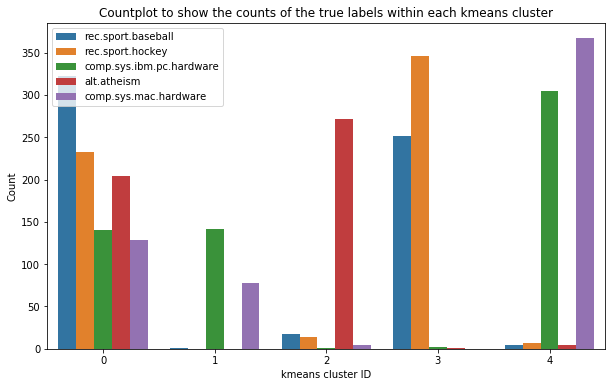

In [187]:
y = np.array(cats)[y_num]

#Plot countplot using y_num (targets in integer form)
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)

plt.xlabel('kmeans cluster ID')
plt.ylabel('Count')
plt.title('Countplot to show the counts of the true labels within each kmeans cluster')

plt.show()

The quality of the fit is not very good at all. The only cluster which contains one main type of data point is the cluster 2. The other clusters all contain a varied mix of datapoint types.

### ========== Question 1.7 --- [8 marks] ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

In [188]:
d = [1,2,3,5,10,20,50,100,500,1000]
adjustedRandScore=[]

#iterate through elements in d, create reduced dimension datasets for each, fit kmeans to each and report intertia and 
#adjusted rand score
for number in d:
    pca1 = PCA(n_components=number, random_state=0)
    X_d = pca1.fit_transform(X)
    kmeans_pca1 = KMeans(n_clusters=5, random_state=0)  
    kmeans_pca1.fit(X_d)
    adjustedRandScore.append(adjusted_rand_score(y_num, kmeans_pca1.labels_))
    print("Number of principal components: {} \n intertia: {} \n adjusted rand score: {} \n".format(number, kmeans_pca1.inertia_, adjusted_rand_score(y_num, kmeans_pca1.labels_)))

Number of principal components: 1 
 intertia: 2.82090668045 
 adjusted rand score: 0.21022329339 

Number of principal components: 2 
 intertia: 10.5777512422 
 adjusted rand score: 0.26815480799 

Number of principal components: 3 
 intertia: 20.4567168883 
 adjusted rand score: 0.240303413586 

Number of principal components: 5 
 intertia: 49.8437604327 
 adjusted rand score: 0.226219157855 

Number of principal components: 10 
 intertia: 117.837311966 
 adjusted rand score: 0.216366066747 

Number of principal components: 20 
 intertia: 230.946050776 
 adjusted rand score: 0.211737649427 

Number of principal components: 50 
 intertia: 488.359379539 
 adjusted rand score: 0.222200977192 

Number of principal components: 100 
 intertia: 800.808058817 
 adjusted rand score: 0.213817491702 

Number of principal components: 500 
 intertia: 2132.35337355 
 adjusted rand score: 0.22465988685 

Number of principal components: 1000 
 intertia: 2593.44863581 
 adjusted rand score: 0.23147506

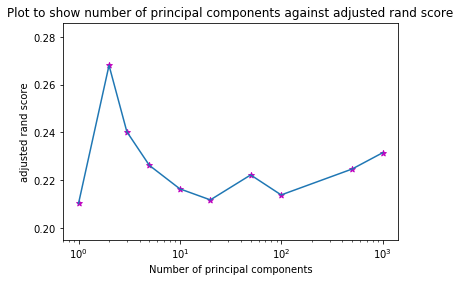

In [189]:
#Plot principal components against adjusted rand score
plt.scatter(d, adjustedRandScore, marker='*', color='m')
plt.plot(d, adjustedRandScore)
plt.title('Plot to show number of principal components against adjusted rand score')
plt.xlabel('Number of principal components')
plt.ylabel('adjusted rand score')
plt.xscale('log')
plt.show()

1. This graph shows that at 2 principal components, the adjusted rand score is the highest, which is what we want, so this is the optimal number of principal components out of the ones we tested (although the real optimum could be a number which we didn't test, but from the graph this number would appear most likely to be not much higher than 2). After 2 principle components, the graph does fluctuate but generally as the number of principal components increases, the adjusted rand score is decreasing (or increasing slightly but not significantly). At 1000 principle components (the maximum as we started with 1000 features), the adjusted rand score is not the highest which is interesting. From this graph, it would be sensible to perform pca with principal components =2.

2. We can't use inerita to choose the best number of principle components because comparing inertia across different dimensions doesn't make much sense. 

3. Euclidean distance doesn't work as we would geometrically expect in higher dimensions and doesn't always make sense in higher dimensions, so reducing dimensions could help kmeans perform better because kmeans does use the Euclidean distance.

### ========== Question 1.8 --- [6 marks] ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

In [190]:
#Part 1 create 2D dataset
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(X)

#Part 2
kmeans_pca = KMeans(n_clusters=5, random_state=0)  
kmeans_pca.fit(X_2d)
ars = adjusted_rand_score(y_num, kmeans_pca.labels_)

print("The adjusted rand score is {}.".format(ars))

The adjusted rand score is 0.26815480799.


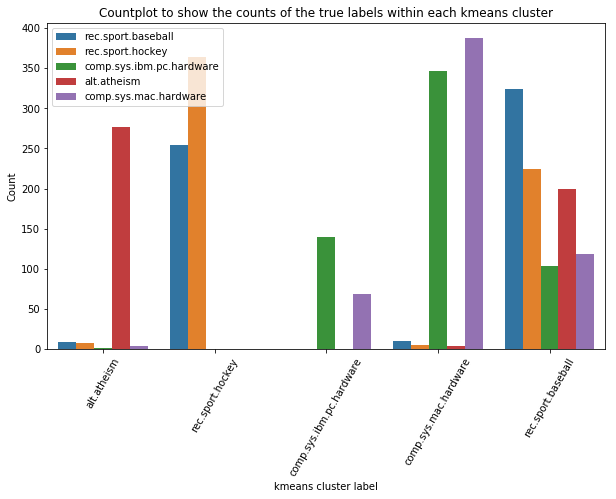

In [191]:
#Part 3
#Plot countplot using y_num (targets in integer form)
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans_pca.labels_, hue=y, ax=ax)

#Set x axes and legend labels to (cats) list (target newsgroup names) to make graph more readable
#ax.legend(cats, title='True labels', loc = 'upper left')
ax.set_xticklabels(['alt.atheism', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware',  'rec.sport.baseball'])

#Rotate xticklabels 90 degrees so that they don't overlap
for label in ax.get_xticklabels():
    label.set_rotation(60)
 

plt.xlabel('kmeans cluster label')
plt.ylabel('Count')
plt.title('Countplot to show the counts of the true labels within each kmeans cluster')

plt.show()

In [192]:
#Display the number of datapoints that kmeans assigned to each target 
print("The number of datapoints that this kmeans assigned to each label are as follows:")
count = collections.Counter(kmeans_pca.labels_)
count

The number of datapoints that this kmeans assigned to each label are as follows:


Counter({0: 298, 1: 618, 2: 209, 3: 752, 4: 968})

The distribution of the true labels in this countplot is practically identical to the distribution in the countplot on the 1000 dimensional data, so they're not any better using 2 dimensional data.

### ========== Question 1.9 --- [1 mark] ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

By looking at the plot above, I can see which type of data each cluster contains most of by seeing which bar is the highest. To give each cluster a label, I will create a list containing labels that I give to each cluster by eyeing the graph, 

In [193]:
#Eye the graph and assign label to each cluster
labels = ['alt.atheism', 'rec.sport.hockey', 'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware',  'rec.sport.baseball']

#Create label_interp by changing kmeans labels which are integers 0 to 4 into their corresponding
#newsgroup name from labels
label_interp = np.array(labels)[kmeans_pca.labels_]
label_interp

array(['rec.sport.baseball', 'rec.sport.hockey', 'rec.sport.hockey', ...,
       'comp.sys.ibm.pc.hardware', 'rec.sport.hockey', 'rec.sport.baseball'],
      dtype='|S24')

### ========== Question 1.10 --- [3 marks] ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

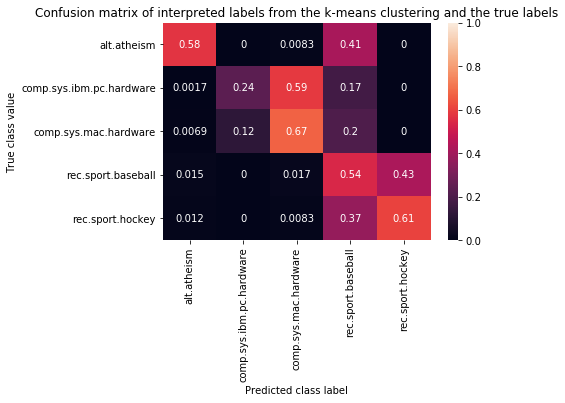

In [194]:
#Creating and plotting the confusion matrix
cm= confusion_matrix(y, label_interp, labels=cats)
cmNorm = cm/ cm.sum(axis=1)[:,np.newaxis]

def plot_confusion_matrix(confusionMatrix, classes=None, title='Confusion matrix'):
    sns.heatmap(confusionMatrix, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    plt.title(title)
    plt.xlabel('Predicted class label')
    plt.ylabel('True class value')
    
plot_confusion_matrix(cmNorm, classes=cats, title='Confusion matrix of interpreted labels from the k-means clustering and the true labels')

### ========== Question 1.11 --- [6 marks] ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

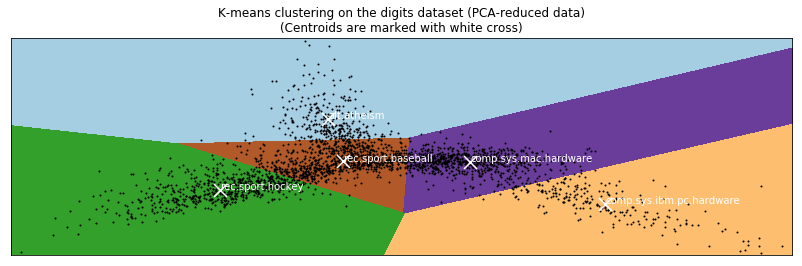

In [220]:
#The copied code uses reduced_data and kmean so change my data to use these names
reduced_data = X_2d
kmeans = KMeans(n_clusters=5, random_state=0)  
kmeans.fit(X_2d)

plt.figure(figsize=(14,4))

#Changed h to a smaller size to get smoother boundaries (although this increases running time)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .0002     # point in the mesh [x_min, x_max]x[y_min, y_max].

#Changed these to make the plot 'zoom in' on the boundaries
# Plot the decision boundary. For that, we will assign a color to each
#Changed -1 and +1 to -0.1 and +0.1 to zoom in on the graph
x_min, x_max = reduced_data[:, 0].min() - 0.01, reduced_data[:, 0].max() + 0.01
y_min, y_max = reduced_data[:, 1].min() - 0.01, reduced_data[:, 1].max() + 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_

#Annotations of cluster labels
for index, centroid in enumerate(labels[:5]):
    plt.annotate(centroid, xy=(centroids[:, 0][index], centroids[:, 1][index]), color='w'),

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10., label=labels)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n(Centroids are marked with white cross)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

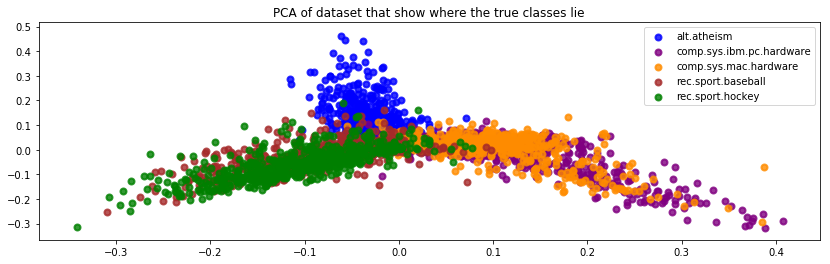

In [196]:
plt.figure(figsize=(14,4))
#Choose colours to similar to that above
colors = ['blue', 'purple', 'darkorange', 'brown','green']

#Choose lightness
lw = 2

#Plot distribution of true labels
for color, i, target_name in zip(colors, cats, cats):
    plt.scatter(reduced_data[y == i, 0], reduced_data[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of dataset that show where the true classes lie')

plt.show()

### ========== Question 1.12 --- [4 marks] ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.2 (fitting k-means) do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

1. If the initial centres are supplied, then kMeans is deterministic because it will always output the same clusters for those given initial clusters. If we say that kMeans selects the initial centres when initialising, then kMeans is not deterministic because it will output different clusters for different initial centres.

2. In question 2, sklearn initialises kmeans 10 times - the kmeans++ initialisation method n_init=10 times, and then selects the clustering with the lowest inertia, then once this clustering is selected, python/jupyter notebook only initialises kmeans once. 

3. We could just set init=random, which just chooses k (number of clusters) random data points from the data as cluster centres. This isn't ideal though as we just get one set of clusters - we don't create multiple and compare their inertias to select the best one, we just end up with what we end up with and it might be a good or bad clustering depending on what initial random centroids were picked.

## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 --- [0 marks] ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [197]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 --- [8 marks] ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. What are the max/min values for each dimension?
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots, answer this question in a markdown cell:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

In [198]:
#See what the object contains
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

In [199]:
#Part 1 
#Convert digits to a pandas dataframe
digitsDf = pd.DataFrame(digits.data)

#Get a feel for range of each dimension
digitsDf.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


In [200]:
#Part 2
print("The maximum values for each dimension are :")
digitsDf.describe()["max":"max"]

The maximum values for each dimension are :


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
max,0.0,8.0,16.0,16.0,16.0,16.0,16.0,15.0,2.0,16.0,...,16.0,13.0,1.0,9.0,16.0,16.0,16.0,16.0,16.0,16.0


In [201]:
print("and the minimum values for each dimension are:")
digitsDf.describe()["min":"min"]

and the minimum values for each dimension are:


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
print("The maximum value out of the maxes for each dimension is: {}".format(digitsDf.max().max()) +
    "\nthe minimum value out of the minimums for each dimension is {}".format(digitsDf.min().min()))

The maximum value out of the maxes for each dimension is: 16.0
the minimum value out of the minimums for each dimension is 0.0


In [203]:
#Part 3
#Extract standard deviations from output of describe method
stds = pd.DataFrame(digitsDf.describe()["std":"std"])
stds

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.19616,...,4.919406,0.984401,0.02359,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122


In [204]:
#Reshape (using .values because there's no built in reshape for pandas dataframes to 8x8 image 
#and use pd.DataFrame at the beginning because otherwise we will get an np.ndarray 
stds = pd.DataFrame(stds.values.reshape(8,8))
stds

,0,1,2,3,4,5,6,7
0,0.000000,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383
1,0.094222,3.196160,5.421456,3.977543,4.782681,6.052960,3.586321,0.827915
2,0.062368,3.576301,5.690767,5.802662,6.175729,6.197322,3.259870,0.438597
3,0.033352,3.146532,6.192038,5.882936,6.152093,5.872556,3.686456,0.047140
4,0.000000,3.480372,6.324687,6.268391,5.933490,5.870648,3.537283,0.000000
5,0.145185,2.981816,6.537955,6.441378,6.259511,5.695527,4.330951,0.307356
6,0.204223,1.746153,5.644496,5.226948,5.302048,6.031154,4.919406,0.984401
7,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122


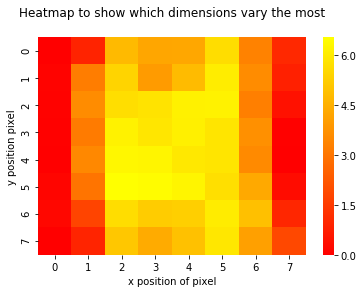

In [205]:
#heatmap to visualise Matrix2, set annot=False so that the heatmap is easier to get a feel of - with the numbers included, 
#it looks too crowded and more difficult to analyse by eye
ax = sns.heatmap(stds, annot=False, cmap="autumn")
ax.set_xlabel('x position of pixel')
ax.set_ylabel('y position pixel')
ax.set_title('Heatmap to show which dimensions vary the most\n')
plt.show()

In [206]:
#get a feel for the data when it's split according to its target digits
digitsDf.groupby(digits.target).describe()

0                                         1             ...      62  \
   count mean  std  min  25%  50%  75%  max  count      mean  ...     75%   
0  178.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  178.0  0.022472  ...    0.00   
1  182.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  182.0  0.010989  ...    4.00   
2  177.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  177.0  0.932203  ...   14.00   
3  183.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  183.0  0.644809  ...    1.00   
4  181.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  181.0  0.000000  ...    0.00   
5  182.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  182.0  0.967033  ...    0.00   
6  181.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  181.0  0.000000  ...    7.00   
7  179.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  179.0  0.167598  ...    0.00   
8  174.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  174.0  0.143678  ...    1.00   
9  180.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  180.0  0.144444  ...    2.25   

            63                                                
    max  count      mean       std  min  25%  50%  75%   max  
0   7.0  178.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  
1  16.0  182.0  1.494505  4.016193  0.0  0.0  0.0  0.0  16.0  
2  16.0  177.0  1.932203  3.630041  0.0  0.0  0.0  2.0  16.0  
3  16.0  183.0  0.065574  0.634247  0.0  0.0  0.0  0.0   8.0  
4   0.0  181.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  
5   8.0  182.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  
6  16.0  181.0  0.093923  0.523892  0.0  0.0  0.0  0.0   6.0  
7   0.0  179.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  
8  16.0  174.0  0.011494  0.151620  0.0  0.0  0.0  0.0   2.0  
9  16.0  180.0  0.055556  0.312178  0.0  0.0  0.0  0.0   3.0  

[10 rows x 512 columns]

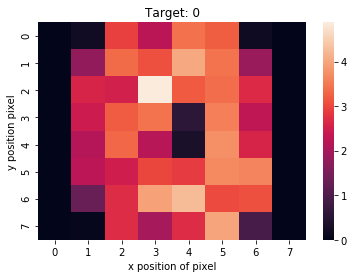

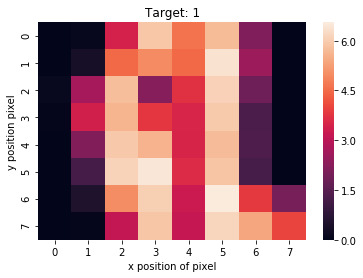

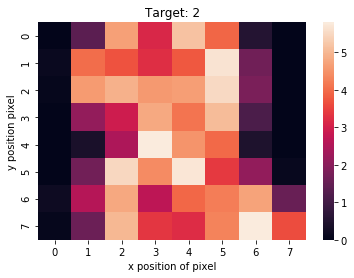

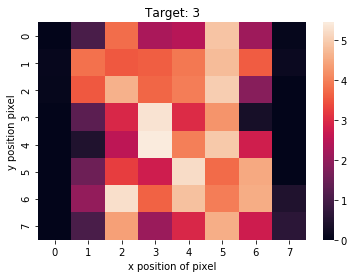

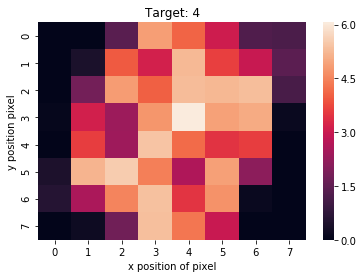

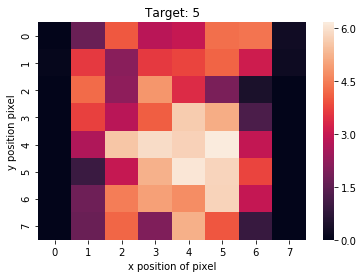

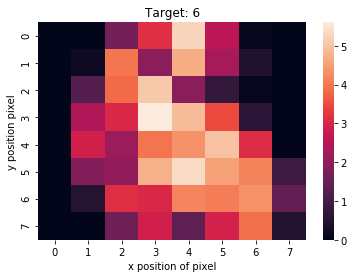

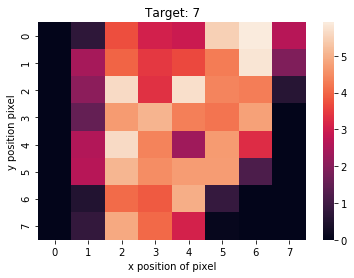

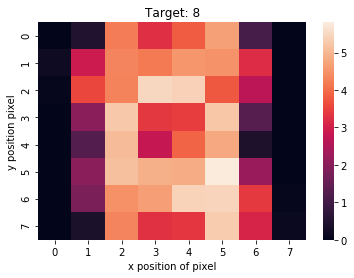

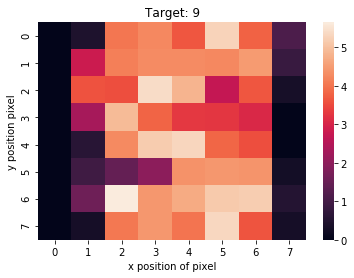

In [207]:
#Part 3 bonus mark 
#Get std values when data is grouped by target digits(0-9). This returns a 10 by 64 numpy.ndarray
ten_targetDigits_std = digitsDf.groupby(digits.target).std().values

#Need to reshape into 10 8x8 arrays so that it's possible to create heatmaps for each target digit
reshaped_ten_targetDigits_std = np.reshape(ten_targetDigits_std, newshape=(len(ten_targetDigits_std),8,8))

#print std heatmap for each target digit
for index, std8x8 in enumerate(reshaped_ten_targetDigits_std):
    ax = sns.heatmap(std8x8)
    ax.set_title("Target: " + str(index))
    ax.set_xlabel('x position of pixel')
    ax.set_ylabel('y position pixel')
    plt.show()

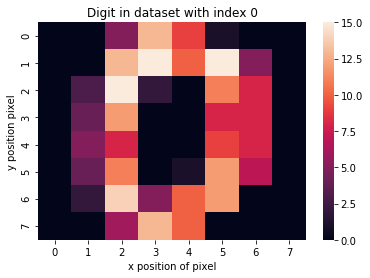

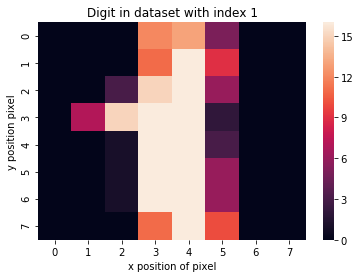

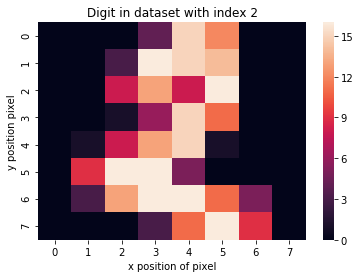

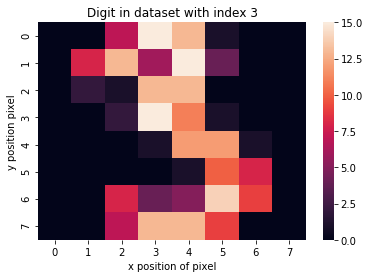

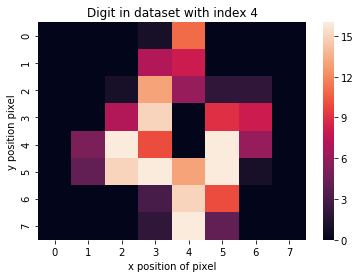

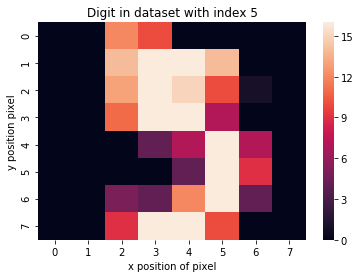

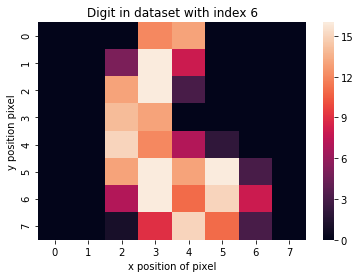

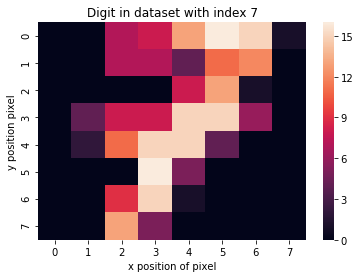

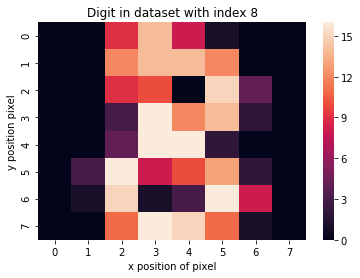

In [208]:
#Part 4
first_9_Digits_in_Dataset = digitsDf.values[:9]

reshaped_first_9_Digits_in_Dataset = np.reshape(first_9_Digits_in_Dataset, newshape=(len(first_9_Digits_in_Dataset),8,8))

for index, digit_num in enumerate(reshaped_first_9_Digits_in_Dataset):
    ax = sns.heatmap(digit_num)
    ax.set_title("Digit in dataset with index {}".format(index))
    ax.set_xlabel('x position of pixel')
    ax.set_ylabel('y position pixel')
    plt.show()

Not all of the dimensions are going to be equally helpful for modelling. As we can see from the heatmap before we split the data into targets (and in fact we can see it on every heatmap thereafter), the first column and last column in the heatmap have standard deviation of practically 0 for every target. Because this doesn't change, it is not going to be helpful for modelling. To illustrate: if the columns are zero for targets 2 and 4, how can a model possibly predict which a digit is supposed to be? 

There are a couple of other locations that are not particularly helpful either for the same reason, namely x position 1, y position 0 and 7. The dimension at x position 2 y position 5 is particularly helpful. It is the brightest on the heatmap so it has the largest standard deviation which means it varies the most out of all the dimensions. This indicates that it is likely to change between targets, so will be useful for modelling. The brighter and more yellow (showing std is higher) the dimension in the first heatmap, the more helpful a dimension is for modelling. 

### ========== Question 2.2 --- [10 marks] ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

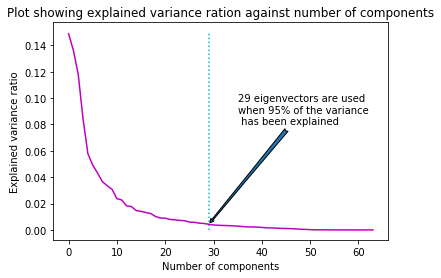

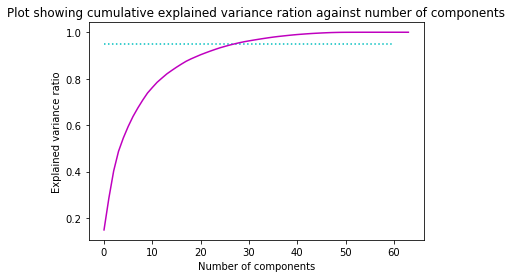

In [209]:
#Create new PCA object and fit with data
pca2 = PCA(n_components=digits.data.shape[1])
pca2.fit(digits.data)

#Find the first index where the cumulative explained ration is larger than 0.95
#Add 1 to the index to find the x value (number of components) because indexing starts from
#0 but number of components starts from 1
xNinetyFive = np.where(pca2.explained_variance_ratio_.cumsum()>0.95)[0][0]+1

#Plot explained variance ration against number of components
plt.plot(pca2.explained_variance_ratio_, color = 'm')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Plot showing explained variance ration against number of components')
plt.vlines(xNinetyFive, 0, 0.15, color = 'c', linestyles='dotted')
plt.annotate(str(xNinetyFive) + " eigenvectors are used \nwhen 95% of the variance\n has been explained ", xytext=(35, 0.08), xy=(xNinetyFive,pca2.explained_variance_ratio_[xNinetyFive]),arrowprops=dict(arrowstyle="fancy", connectionstyle="arc3"))
plt.show()


#Plot cumulative explained variance ration against number of components
plt.plot(pca2.explained_variance_ratio_.cumsum(), color = 'm')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.title('Plot showing cumulative explained variance ration against number of components')
plt.hlines(0.95, 0, 60, color = 'c', linestyles='dotted')
plt.show()

The plots show me that with 30 principle components, 95% of the variance is explained. This means that would could represent our data using these 30 features rather than the original 64, and this would mean that our calculations would be less computationally expensive, which is a good thing. 

### ========== Question 2.3 --- [8 marks] ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

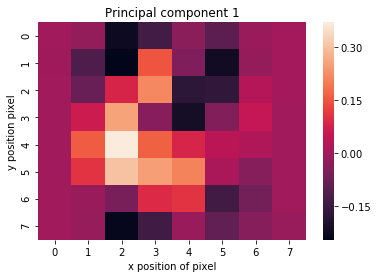

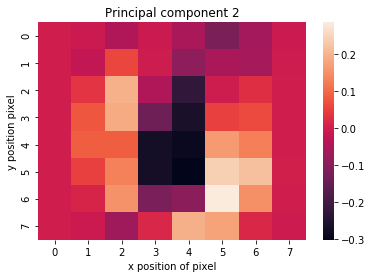

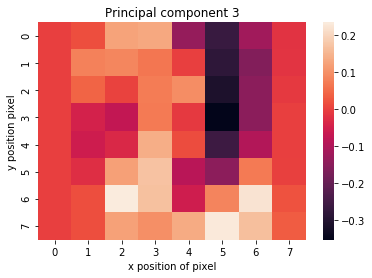

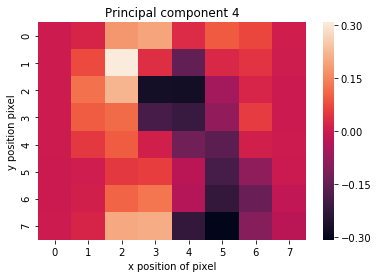

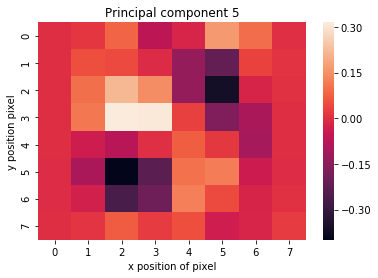

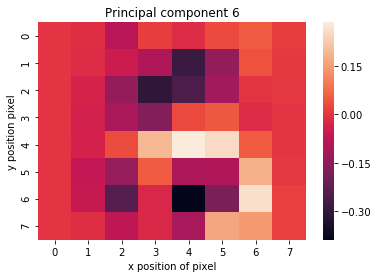

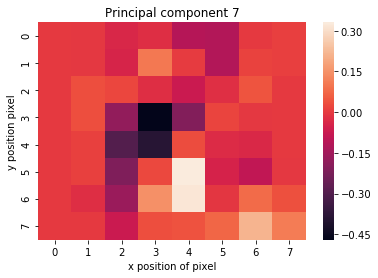

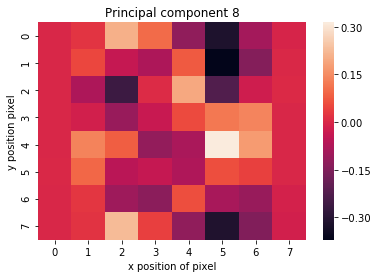

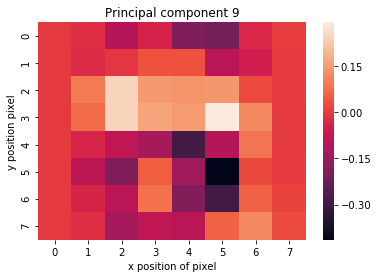

In [210]:
#Get the 9x64 array of the first 9 principal components
first_9_Principal_Components = pca2.components_[:9]

#Reshape components into 9 8x8 arrays so I can plot heatmaps
reshaped_first_9_Principal_Components = np.reshape(first_9_Principal_Components, newshape=(9,8,8))

#For each principal component, plot heatmaps to show how correlated the principal component is
#with each column/feature/pixel (all same thing)
for index, digit_num in enumerate(reshaped_first_9_Principal_Components):
    ax = sns.heatmap(digit_num)
    ax.set_title("Principal component {}".format(index+1))
    ax.set_xlabel('x position of pixel')
    ax.set_ylabel('y position pixel')
    plt.show()
    

64


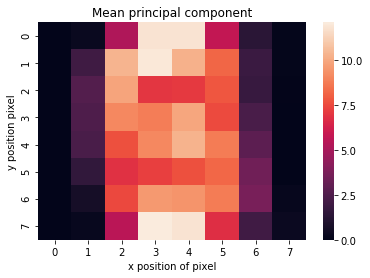

In [211]:
#Check for my own sanity that the pca2_mean is in fact 64 (it is)
print(len(pca2.mean_))

#Reshape to 8x8 so I can plot heatmap
reshaped_pca2_mean = np.reshape(pca2.mean_, newshape=(8,8))

#Plot heatmap of pca2_mean
ax = sns.heatmap(reshaped_pca2_mean)
ax.set_title("Mean principal component")
ax.set_xlabel('x position of pixel')
ax.set_ylabel('y position pixel')
plt.show()


### ========== Question 2.4 --- [10 marks] ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

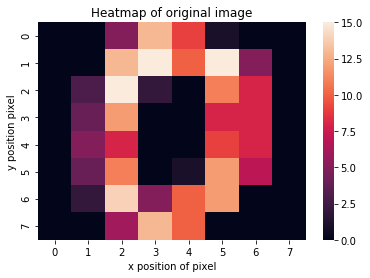

In [212]:
zeroImage = digits.images[0]

sns.heatmap(zeroImage)
plt.title('Heatmap of original image')
plt.xlabel('x position of pixel')
plt.ylabel('y position pixel')
plt.show()

In [213]:
def heatMapwithSoManyPrincipleComponents(i):   
    noPCs = i
    percentageVarianceExplained = pca2.explained_variance_ratio_.cumsum()[i-1]
    transform_pca_space = pca2.transform(digits.data[0,:].reshape(1, -1)).flatten()[:i]
    coefficients = []
    for coefficient in transform_pca_space:
         coefficients.append(round(coefficient))
    PCcomponents = pca2.components_[:i]
    reconstructed = np.dot(transform_pca_space, PCcomponents) +  pca2.mean_
    reconstructed = reconstructed.reshape(8,8)
    sns.heatmap(reconstructed)
    plt.title("Heatmap showing reconstructed digit with {} principal components \nused with respective coefficients {} \nwhich explain {} of the variance".format(noPCs, coefficients, percentageVarianceExplained))
    plt.xlabel('x position of pixel')
    plt.ylabel('y position pixel')
    plt.show()

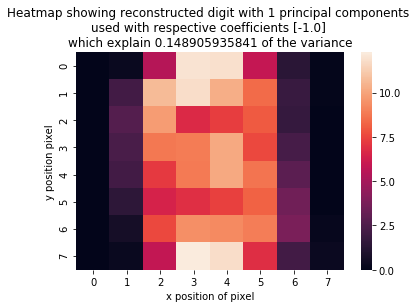

In [214]:
heatMapwithSoManyPrincipleComponents(1)

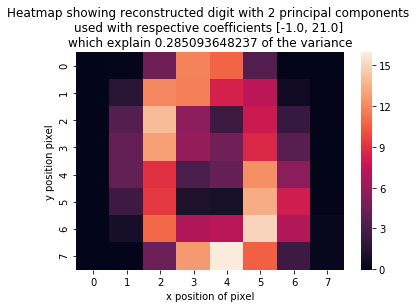

In [215]:
heatMapwithSoManyPrincipleComponents(2)

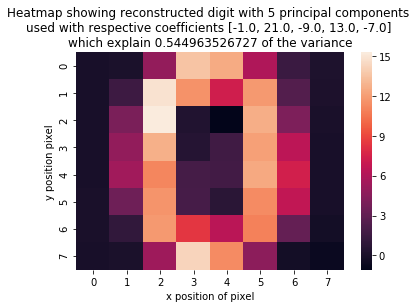

In [216]:
heatMapwithSoManyPrincipleComponents(5)

### ========== Question 2.5 --- [14 marks] ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved when we used PCA, but the other did not!

In [217]:
#Leaving this commented to remind myself what I used in component pca above
#pca2 = PCA(n_components=digits.data.shape[1])
#pca2.fit(digits.data)

#Checking it did in fact use 64 components (it did)
#digits.data.shape[1]

#Transforming the digit data
transformedData = pca2.transform(digits.data)

#Initialise and fit the models
gaussian = GaussianNB()
gaussian.fit(digits.data, digits.target)

gaussian2 = GaussianNB()
gaussian2.fit(transformedData, digits.target)

svc_linear = SVC(kernel='linear', random_state=0, shrinking=False)
svc_linear.fit(digits.data, digits.target)

svc_linear2 = SVC(kernel='linear', random_state=0, shrinking=False)
svc_linear2.fit(transformedData, digits.target)

#Make a 3-cross-validation object. Set shuffle=True as the datapoints in the dataset are in order - they repeat the digits
#0 through 9 repeatedly. Set a random state so I could reproduce results
kfold = KFold(n_splits=5, random_state=0, shuffle=True)

In [218]:
#Calculate mean cross validated accuracy scores 
crossvalLinear = cross_val_score(svc_linear, digits.data, digits.target,cv=kfold)
crossvalLinear_pca = cross_val_score(svc_linear2, transformedData, digits.target, cv=kfold)
crossvalGaussian = cross_val_score(gaussian, digits.data, digits.target, cv=kfold)
crossvalGaussian_pca = cross_val_score(gaussian2, transformedData, digits.target, cv=kfold)

print("Mean cross validated accuracy scores:\n\nLinear: {}\nLinear with PCA: {}\nGaussian Naive Bayes: {}\nGaussian Naive Bayes with PCA: {}".format(np.mean(crossvalLinear), np.mean(crossvalLinear_pca), np.mean(crossvalGaussian), np.mean(crossvalGaussian_pca)))


Mean cross validated accuracy scores:

Linear: 0.984422779325
Linear with PCA: 0.984422779325
Gaussian Naive Bayes: 0.833611884865
Gaussian Naive Bayes with PCA: 0.88872175797


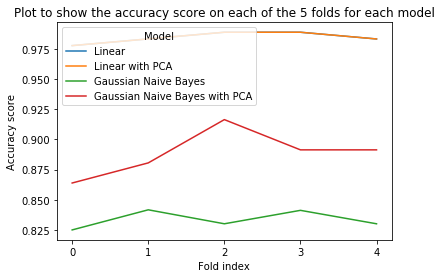

In [219]:
#Plot to show the accuracy score on each of the 5 folds for each model
plt.plot([0,1,2,3,4], cross_val_score(svc_linear, digits.data, digits.target,cv=kfold), label='Linear')
plt.plot([0,1,2,3,4], cross_val_score(svc_linear2, transformedData, digits.target, cv=kfold), label='Linear with PCA')
plt.plot([0,1,2,3,4], cross_val_score(gaussian, digits.data, digits.target,cv=kfold), label='Gaussian Naive Bayes')
plt.plot([0,1,2,3,4], cross_val_score(gaussian2, transformedData, digits.target, cv=kfold), label='Gaussian Naive Bayes with PCA')
plt.xticks([0,1,2,3,4])
plt.xlabel('Fold index')
plt.ylabel('Accuracy score')
plt.title('Plot to show the accuracy score on each of the 5 folds for each model')
plt.legend(title='Model', loc='upper left')
plt.show()

As I can see from the printed accuracy scores and the graph above, the linear model does not improve or change with PCA (we can't even see the two separate lines on the graph as they are exactly on top of each other, and the mean cross validated accuracy scores are both exactly 0.98442277932528621. 

However, the Naive Bayes Gaussian classifier improves from mean CV accuracy across five folds from 0.83361188486536675 to 0.8887217579696689. It increases because Naive Bayes makes the assumption that all features are independent. In the original data, this won't have been strictly true and some features will have had dependence with each other. PCA transforms the original features and all the new PCA features are orthogonal to each other, which means that they are all independent so the Naive Bayes assumption is actually upheld and the model accuracy improves. The linear SVC does not make an independence assumption and so it did not improve with PCA>